# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_21662/4110962823.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [6]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Trotter Gate

In [7]:
def trotter_gate(dt, to_instruction = True):
    qc = QuantumCircuit(2)
    qc.rx(2*dt,0)
    qc.rz(2*dt,1)
    qc.h(1)
    qc.cx(1,0)
    qc.rz(-2*dt, 0)
    qc.rx(-2*dt, 1)
    qc.rz(2*dt, 1)
    qc.cx(1,0)
    qc.h(1)
    qc.rz(2*dt, 0)
    return qc.to_instruction() if to_instruction else qc

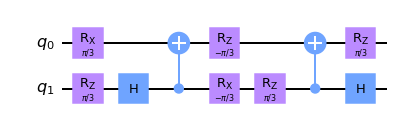

In [8]:
trotter_gate(np.pi / 6, to_instruction=False).draw("mpl")

# Set Parameters

In [9]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')
# Convert custom quantum circuit into a gate
Trot_gate = trotter_gate(dt)

# Make Quantum Circuit

# Set Backend

In [10]:
from qiskit.test.mock import FakeJakarta
backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")
# backend = provider.get_backend("ibmq_jakarta")

# Execute Circuits

In [11]:
jobs = []
st_qcs_list = []
shots = 1 << 13
# Number of trotter steps
trotter_steps = 8  ### CAN BE >= 4
for num_steps in range(1, trotter_steps + 1, 1):
    print("trotter step: ", num_steps)
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(num_steps):
        qc.append(Trot_gate, [qr[3], qr[5]])

    qc.cx(qr[3], qr[1])
    qc.cx(qr[5], qr[3])

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.bind_parameters({dt: target_time/num_steps})
    t3_qc = transpile(qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(t3_qc, [qr[1], qr[3], qr[5]])
    st_qcs_list.append(st_qcs)

    # execute
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)
    print()

trotter step:  1
Job ID 16e33348-d934-4586-afda-98211a9e74e1

trotter step:  2
Job ID b11b299e-5db9-4717-b43d-a0897413d225

trotter step:  3
Job ID 91c1d770-da02-4747-92d2-c16f27744afd

trotter step:  4
Job ID 37719c1f-6383-4314-935e-57d30751ba7f

trotter step:  5
Job ID e77a25ec-e99d-41fb-86fa-d465aeb4f0f4

trotter step:  6
Job ID cda809d8-3f72-4465-9a7f-8f34f5a7da03

trotter step:  7
Job ID 975ed3b6-df20-4f7a-b85c-f36cb4a65ff5

trotter step:  8
Job ID d4b15897-0ebf-4b4c-b6aa-61d076ca9072



# QREM

In [12]:
# QREM
qr = QuantumRegister(num_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout=[5,3,1])
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

In [13]:
results = []
for job in jobs:
    results.append( job.result() )

In [14]:
mit_results = []
for job in jobs:
    mit_results.append( meas_fitter.filter.apply(job.result()) )

In [15]:
len(results), len(mit_results)

(8, 8)

# State Tomography

In [16]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute Fidelity

In [17]:
# Compute tomography fidelities for each repetition
raw_fids = []
for result in results:
    fid = state_tomo(result, st_qcs)
    raw_fids.append(fid)
    
# print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

In [18]:
# Compute tomography fidelities for each repetition
fids = []
for result in mit_results:
    fid = state_tomo(result, st_qcs)
    fids.append(fid)
    
# print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

Text(0, 0.5, 'fidelity')

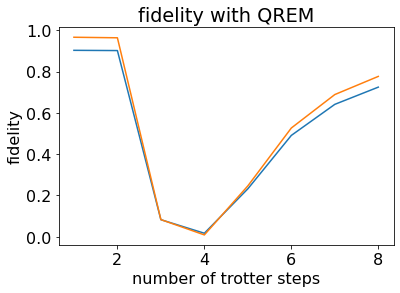

In [20]:
plt.clf()
plt.title("fidelity with QREM")
plt.plot(range(1, trotter_steps + 1, 1), raw_fids)
plt.plot(range(1, trotter_steps + 1, 1), fids)
plt.xlabel("number of trotter steps")
plt.ylabel("fidelity")

In [21]:
for i, fid in enumerate(raw_fids):
    print(i+1, fid)

1 0.9033925000792128
2 0.9022230655737514
3 0.08246518787649207
4 0.01683277036044769
5 0.23209213472300327
6 0.49097655414668634
7 0.6415233096684553
8 0.7249709925988207


In [22]:
for i, fid in enumerate(fids):
    print(i+1, fid)

1 0.9668007955103022
2 0.9641542262979681
3 0.08298039702924138
4 0.00868564338346413
5 0.24627905866505195
6 0.5268630223149782
7 0.6890151346887323
8 0.7769617034019429


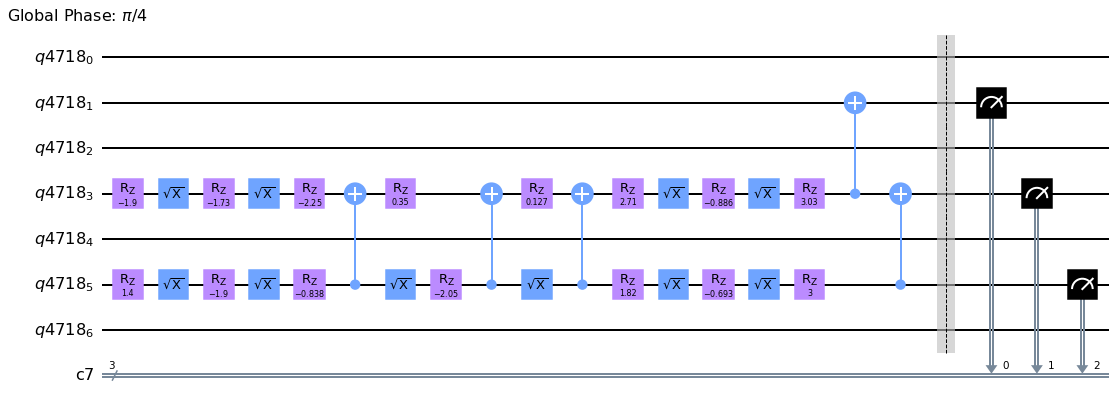

In [23]:
st_qcs_list[-1][-1].draw("mpl")

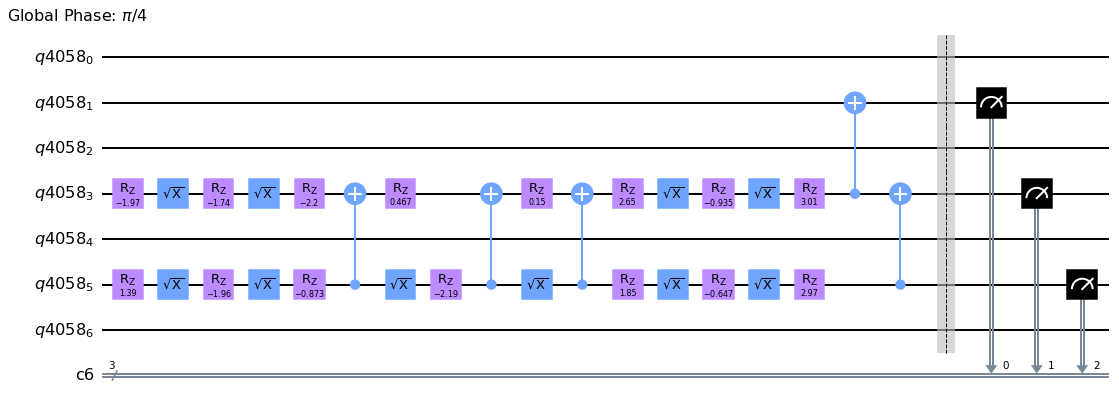

In [24]:
st_qcs_list[-2][-1].draw("mpl")